In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Load the data set we will be working with
"""

data_dir = 'Datasets'
dataset_name = 'Lynx and Hare'

df = pd.read_csv(f'{data_dir}/Lynx_Hare/data.csv')
df.drop(columns = 'DATE', inplace = True)
df = (df - df.mean()) / df.std()
display(df)

,HARE,LYNX
0,-0.709999,0.092948
1,-0.709449,0.891274
2,-0.709174,1.103313
3,-0.918656,0.592829
4,-0.477424,-0.376719
...,...,...
86,-0.711648,-1.061604
87,1.009020,-0.653429
88,1.219327,-0.186414
89,0.996649,0.072274


In [3]:
"""
Set the parameters for the linear regression here
"""

# We will look at the last three values for each species and try to predict the next value using linear regression
lag = 2

expected = df.iloc[lag:, :]
display(expected)

,HARE,LYNX
2,-0.709174,1.103313
3,-0.918656,0.592829
4,-0.477424,-0.376719
5,0.346210,-1.055773
6,0.802562,-1.207381
...,...,...
86,-0.711648,-1.061604
87,1.009020,-0.653429
88,1.219327,-0.186414
89,0.996649,0.072274


In [4]:
def predict(index, species, df, lag):
    data = df.loc[index - lag : index - 1, species]

    y = data.to_numpy()
    x = np.arange(start = index - lag, stop = index)
    
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return m * index + c


In [5]:
predicted = np.array([[predict(index, species, df, lag) for index in range(lag, len(df))] for species in df.columns])

In [6]:
error = pd.DataFrame()

for i, column in enumerate(df.columns):
    error[column] = pd.Series((expected.to_numpy().T - predicted)[i])

display(error)

,HARE,LYNX
0,-0.000275,-0.586288
1,-0.209757,-0.722523
2,0.650714,-0.459064
3,0.382401,0.290493
4,-0.367281,0.527447
...,...,...
84,0.369755,0.715101
85,1.300329,0.337672
86,-1.510361,0.058841
87,-0.432985,-0.208328


In [7]:
import torch
from torcheval.metrics.functional import r2_score

import statistics

np_error = error.to_numpy()
mse_loss = np.mean(np_error * np_error)
r2_loss = statistics.fmean([r2_score(torch.tensor(predicted[i]), torch.tensor(expected[o].tolist())) for i, o in enumerate(expected.columns)])
l1_loss = np.mean(np.abs(np_error))

print(f'MSE: {mse_loss:.4f}')
print(f'R2 Score: {r2_loss:.4f}')
print(f'MAE: {l1_loss:.4f}')

MSE: 0.7436
R2 Score: 0.2567
MAE: 0.5624


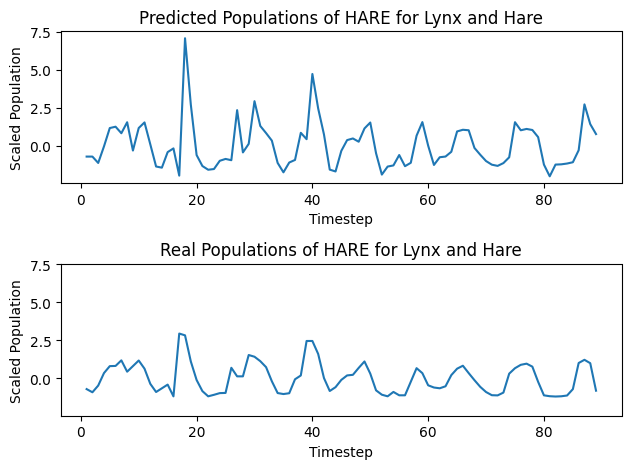

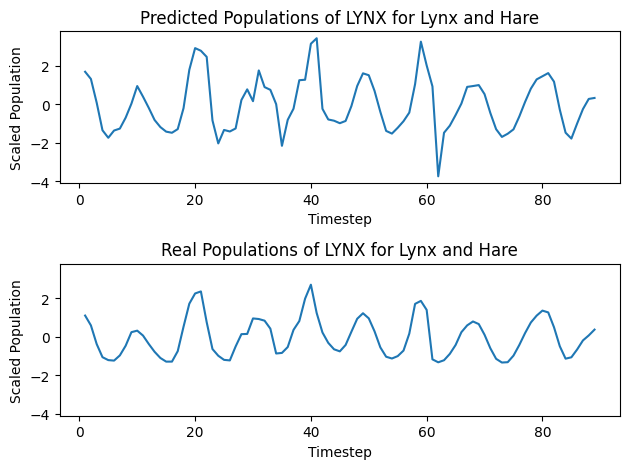

In [8]:
for i, s in enumerate(expected.columns):
    fig, (p, r) = plt.subplots(2, sharey = True)
    
    p.plot(range(1, len(predicted[i]) + 1), predicted[i])
    p.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    p.set_xlabel('Timestep')
    p.set_ylabel('Scaled Population')
    r.plot(range(1, len(predicted[i]) + 1), expected[s].tolist())
    r.title.set_text(f'Real Populations of {s} for {dataset_name}')
    r.set_xlabel('Timestep')
    r.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()